In [1]:
!pip install opendatasets
!pip install pandas
!pip install tensorflow
!pip install gdown

In [2]:
import os
import cv2
import glob
import math
import shutil
import random
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import multiprocessing
import tensorflow as tf
from pathlib import Path
import concurrent.futures
import keras.backend as K
from time import perf_counter
from functools import lru_cache
import matplotlib.pyplot as plt
from keras import layers, models
from PIL import Image, ImageEnhance
from joblib import Parallel, delayed
from collections import defaultdict, Counter
from sklearn.preprocessing import LabelEncoder
from keras.metrics import Precision, Recall, AUC
from keras.callbacks import LearningRateScheduler
from keras.utils import plot_model, to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.metrics import accuracy_score, classification_report

In [3]:
import os
import cv2
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from time import perf_counter
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from keras.metrics import Precision, Recall, AUC
from tensorflow.keras.layers import ReLU, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation , GlobalAveragePooling2D ,DepthwiseConv2D ,Input ,Add ,Concatenate

In [4]:
!gdown "https://drive.google.com/uc?id=1QAkYNXInCNX35b2lI8dXHFvVjor9AIVk"
zip_path = "/kaggle/working/Copy of Copy of train.zip"  # Path to the ZIP file
extracted_path = "/kaggle/working/chest_ctscan_images"  # Path to extract the files
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)
train_dir = os.path.join(extracted_path, "train")
valid_dir = "/kaggle/working/chest_ctscan_images/valid"
test_dir = "/kaggle/working/chest_ctscan_images/test"

Downloading...
From (original): https://drive.google.com/uc?id=1QAkYNXInCNX35b2lI8dXHFvVjor9AIVk
From (redirected): https://drive.google.com/uc?id=1QAkYNXInCNX35b2lI8dXHFvVjor9AIVk&confirm=t&uuid=fb6c664b-3905-4622-9d22-f26bdc7a1651
To: /kaggle/working/Copy of Copy of train.zip
100%|████████████████████████████████████████| 124M/124M [00:01<00:00, 68.1MB/s]


In [5]:
# Create a validation set from a portion of the training set
def create_validation_set(source_dir, validation_dir, validation_ratio=0.2):
    if not os.path.exists(validation_dir):
        os.makedirs(validation_dir)

    for class_name in os.listdir(source_dir):
        class_source_path = os.path.join(source_dir, class_name)
        class_valid_path = os.path.join(validation_dir, class_name)

        if not os.path.exists(class_valid_path):
            os.makedirs(class_valid_path)

        all_files = os.listdir(class_source_path)
        train_files, valid_files = train_test_split(all_files, test_size=validation_ratio, random_state=42)

        for file in valid_files:
            shutil.move(os.path.join(class_source_path, file), os.path.join(class_valid_path, file))

create_validation_set(train_dir, valid_dir, validation_ratio=0.2)

In [6]:
# Example code to create a test set from a portion of the training set
def create_test_set(source_dir, test_dir, test_ratio=0.1):
    # Create test directory if it doesn't exist
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    for class_name in os.listdir(source_dir):
        class_source_path = os.path.join(source_dir, class_name)
        class_test_path = os.path.join(test_dir, class_name)

        if not os.path.exists(class_test_path):
            os.makedirs(class_test_path)

        all_files = os.listdir(class_source_path)
        train_files, test_files = train_test_split(all_files, test_size=test_ratio, random_state=42)

        for file in test_files:
            shutil.move(os.path.join(class_source_path, file), os.path.join(class_test_path, file))

create_test_set(train_dir, test_dir, test_ratio=0.18)  # Split 10% for test

In [7]:
train_datagen = ImageDataGenerator()
valid_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [8]:
valid_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical'
)

Found 654 images belonging to 4 classes.


In [9]:
validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical'
)

Found 201 images belonging to 4 classes.


In [10]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical'
)
os.makedirs(test_dir, exist_ok=True)

Found 145 images belonging to 4 classes.


In [11]:
import random
random.seed(20)

In [12]:

# Define the input
input_layer = keras.Input(shape=(224, 224, 3))

# Block 1
x = Conv2D(32, (3,3), activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Block 2
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Block 3
block3_output = Conv2D(96, (3,3), activation='relu', padding='same')(x)
block3_output = BatchNormalization()(block3_output)
block3_output = MaxPooling2D((2, 2))(block3_output)

# Block 4
x = DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation='relu')(block3_output)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
block4_branch = Conv2D(64, (1,1), activation='relu', padding='same')(x)
x = Conv2D(160, (3, 3), activation='relu', padding='same')(block4_branch)
x = BatchNormalization()(x)
x = DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation='relu')(x)
block4_output = DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation='relu')(x)

# block3_out = Conv2D(32, (1,1), activation='relu', padding='same')(block3_output)
# block3_out = Conv2D(96, (3, 3), activation='relu', padding='same', dilation_rate=2)(block3_out)
x = Concatenate()([block4_output,  block3_output])
x = MaxPooling2D((2, 2))(x)

# Block 5
x = DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation='relu')(x)
x = Conv2D(192, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(96, (1,1), activation='relu', padding='same')(x)
x = Conv2D(224, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation='relu')(x)
x = DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation='relu')(x)

# MaxPooling before Block 6
main_branch_output = MaxPooling2D((2, 2))(x)
main_branch_output = BatchNormalization()(main_branch_output)

y1 = layers.MaxPooling2D((2, 2), padding="same", strides=(1, 1), name='MaxPooling2D_y1')(block4_branch)
y2 = layers.AvgPool2D((2, 2), padding="same", strides=(1, 1), name='AvgPool2D_y2')(block4_branch)
concat = layers.Concatenate()([y1, y2])

y4 = layers.Conv2D(32, (3, 3), padding='same', dilation_rate=2, name='Conv2D_y2')(concat)

y4 = layers.BatchNormalization(name='BatchNormalization_y')(y4)
y4 = layers.ReLU()(y4)
concat_m = layers.Concatenate()([y4, block4_branch])
z = layers.MaxPooling2D((2, 2), strides=(2, 2), name='MaxPooling2D_z')(concat_m)

main_branch_gap = GlobalAveragePooling2D()(main_branch_output)
parallel_branch_gap = GlobalAveragePooling2D()(z)

# Concatenate the GAP outputs
x = Concatenate()([main_branch_gap, parallel_branch_gap])
# x = GlobalAveragePooling2D()(main_branch_output)

# Output layer
output_layer = Dense(4, activation='softmax')(x)

# Define the model
model = Model(inputs=input_layer, outputs=output_layer)

# Print the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 32)   │              0 │ batch_normalization[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 112, 112, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 64)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 56, 56, 96)     │         55,392 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 56, 56, 96)     │            384 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 28, 28, 96)     │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv2d          │ (None, 28, 28, 96)     │            960 │ max_pooling2d_2[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 28, 28, 128)    │        110,720 │ depthwise_conv2d[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 28, 28, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 28, 28, 64)     │          8,256 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 28, 28, 160)    │         92,320 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 994,916 (3.80 MB)

 Trainable params: 992,612 (3.79 MB)

 Non-trainable params: 2,304 (9.00 KB)

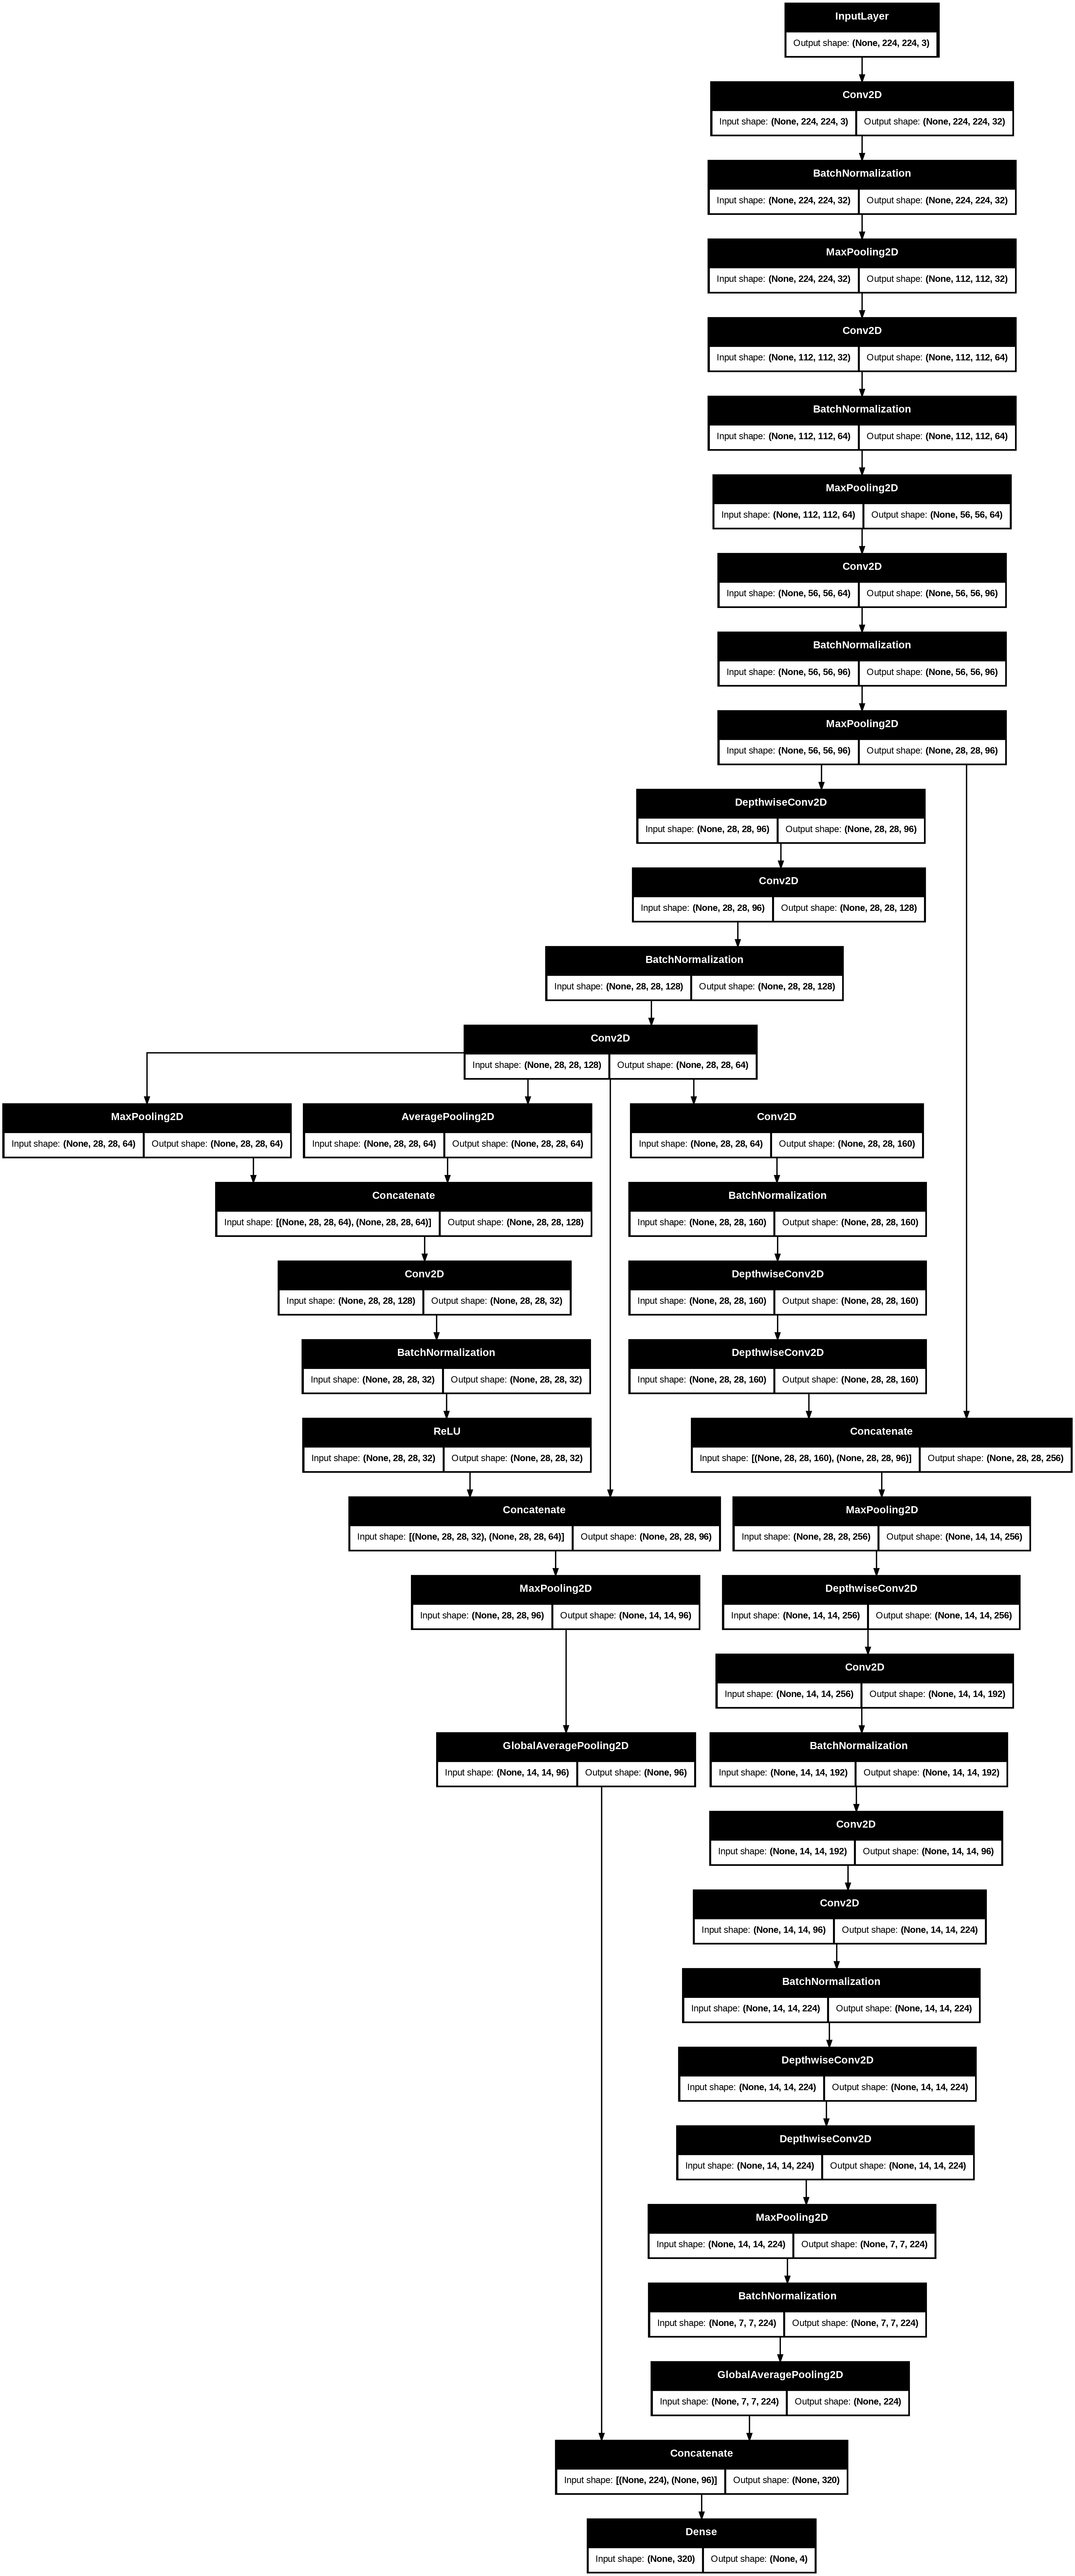

In [13]:
plot_model(model, show_shapes=True)

In [14]:
def create_metrics():
    """
    Creates instances of various metrics for evaluating model performance.

    Returns:
        tuple: A tuple of the metrics: (recall, precision, f1_score, auc, sensitivity, specificity, mcc).
    """
    @tf.function
    def f1_score(y_true, y_pred):
        """
        Calculates the F1 score.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: F1 score.
        """
        tp = true_positive(y_true, y_pred)
        fp = false_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        precision = tp / (tp + fp + tf.keras.backend.epsilon())
        recall = tp / (tp + fn + tf.keras.backend.epsilon())

        return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

    @tf.function
    def specificity(y_true, y_pred):
        """
        Calculates the specificity.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Specificity.
        """
        tn = true_negative(y_true, y_pred)
        fp = false_positive(y_true, y_pred)

        return tn / (tn + fp + tf.keras.backend.epsilon())

    @tf.function
    def sensitivity(y_true, y_pred):
        """
        Calculates the sensitivity.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Sensitivity.
        """
        tp = true_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        return tp / (tp + fn + tf.keras.backend.epsilon())

    @tf.function
    def mcc(y_true, y_pred):
        """
        Calculates the Matthews correlation coefficient (MCC).

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Matthews correlation coefficient.
        """
        tp = true_positive(y_true, y_pred)
        tn = true_negative(y_true, y_pred)
        fp = false_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        numerator = (tp * tn - fp * fn)
        denominator = tf.keras.backend.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

        return numerator / (denominator + K.epsilon())

    @tf.function
    def true_positive(y_true, y_pred):
        """
        Calculates the number of true positives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of true positives.
        """
        y_pred_pos, _, y_pos, _ = calculate_confusion_matrix(y_true, y_pred)
        return tf.reduce_sum(y_pos * y_pred_pos)

    @tf.function
    def false_positive(y_true, y_pred):
        """
        Calculates the number of false positives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of false positives.
        """
        y_pred_pos, _, _, y_neg = calculate_confusion_matrix(y_true, y_pred)
        return tf.reduce_sum(y_neg * y_pred_pos)

    @tf.function
    def false_negative(y_true, y_pred):
        """
        Calculates the number of false negatives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of false negatives.
        """
        _, y_pred_neg, y_pos, _ = calculate_confusion_matrix(y_true, y_pred)
        return tf.reduce_sum(y_pos * y_pred_neg)

    @tf.function
    def true_negative(y_true, y_pred):
        """
        Calculates the number of true negatives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of true negatives.
        """
        _, y_pred_neg, _, y_neg = calculate_confusion_matrix(y_true, y_pred)
        return tf.reduce_sum(y_neg * y_pred_neg)

    @tf.function
    def calculate_confusion_matrix(y_true, y_pred):
        """
        Calculates the components of the confusion matrix.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            tuple: A tuple containing the components of the confusion matrix: (y_pred_pos, y_pred_neg, y_pos, y_neg).
        """
        import tensorflow as tf

        y_pred_pos = tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1))
        y_pred_neg = 1 - y_pred_pos
        y_pos = tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1))
        y_neg = 1 - y_pos
        return y_pred_pos, y_pred_neg, y_pos, y_neg

    precision = Precision()
    recall = Recall()
    f1_score = f1_score
    specificity = specificity
    sensitivity = sensitivity
    mcc = mcc
    auc = AUC()

    return (
        precision,
        recall,
        f1_score,
        specificity,
        sensitivity,
        mcc,
        auc,
    )

In [15]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, EarlyStopping

# Call the function to get all the metrics
precision, recall, f1_score, specificity, sensitivity, mcc, auc = create_metrics()

# Now compile the model with the retrieved metrics
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', precision, recall, f1_score, specificity, sensitivity, mcc, auc]
)


In [16]:
initial_learning_rate=0.0005

def lr_scheduler(epoch, lr):
    if epoch < 7:
      return lr
    else:
      return lr * 0.95

lr_callback = LearningRateScheduler(lr_scheduler)

In [17]:

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

optimizer_ad = Adam(learning_rate=initial_learning_rate)

start_time = perf_counter()

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=35,
    callbacks=[lr_callback]
)
end_time = perf_counter()

Epoch 1/35


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 529ms/step - accuracy: 0.4723 - auc: 0.7723 - f1_score: 0.3330 - loss: 1.0625 - mcc: 0.3081 - precision: 0.6940 - recall: 0.2314 - sensitivity: 0.2311 - specificity: 0.9670 - val_accuracy: 0.2139 - val_auc: 0.5529 - val_f1_score: 0.2105 - val_loss: 3.9285 - val_mcc: -0.0527 - val_precision: 0.2139 - val_recall: 0.2139 - val_sensitivity: 0.2105 - val_specificity: 0.7368 - learning_rate: 0.0010
Epoch 2/35
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.6222 - auc: 0.8741 - f1_score: 0.4691 - loss: 0.8417 - mcc: 0.4363 - precision: 0.7892 - recall: 0.3525 - sensitivity: 0.3507 - specificity: 0.9679 - val_accuracy: 0.3184 - val_auc: 0.6337 - val_f1_score: 0.3057 - val_loss: 1.3456 - val_mcc: 0.2501 - val_precision: 0.5915 - val_recall: 0.2090 - val_sensitivity: 0.2094 - val_specificity: 0.9523 - learning_rate: 0.0010
Epoch 3/35
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.7076 - auc: 0.9140 - f1_score: 0.6433 - loss: 0.7161 - mcc: 0.5702 - prec

In [18]:
execution_time = end_time - start_time

milliseconds = int(execution_time * 1000)
seconds, milliseconds = divmod(milliseconds, 1000)
minutes, seconds = divmod(seconds, 60)
hours, minutes = divmod(minutes, 60)

time_string = f"{hours} hours, " if hours else ""
time_string += f"{minutes} minutes, " if minutes else ""
time_string += f"{seconds} seconds, " if seconds else ""
time_string += f"{milliseconds} milliseconds"

print(f"Model training took {time_string}")

Model training took 3 minutes, 7 seconds, 677 milliseconds


In [19]:
_ = model.evaluate(test_generator, verbose=2)

10/10 - 3s - 302ms/step - accuracy: 0.9241 - auc: 0.9906 - f1_score: 0.9312 - loss: 0.2211 - mcc: 0.9083 - precision: 0.9241 - recall: 0.9241 - sensitivity: 0.9312 - specificity: 0.9771


In [20]:
def plot_metrics(hist, metric_name_list):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        hist: a Keras History object containing the training history
        metric_name_list: a list of strings representing the names of the metrics to plot

    Returns:
        None
    """
    num_metrics = len(metric_name_list)

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))

    rng = range(1, len(hist.history[metric_name_list[0]]) + 1)

    for ax, metric_n in zip(axes, metric_name_list):
        metric = hist.history[metric_n]
        v_metric = hist.history[f"val_{metric_n}"]

        ax.plot(rng, metric, label=metric_n)
        ax.plot(rng, v_metric, label=f"val_{metric_n}")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_n in ("auc", "mcc"):
            ax.set_ylabel(metric_n.upper())
            ax.set_title(metric_n.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_n.capitalize())
            ax.set_title(metric_n.capitalize() + " vs Epochs")

        max_loss = max(max(metric), max(v_metric))
        min_loss = min(min(metric), min(v_metric))
        y_max = math.ceil(max_loss)

        if min_loss > 0 or max_loss > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_loss, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, len(metric))

    plt.tight_layout()

    plt.show()

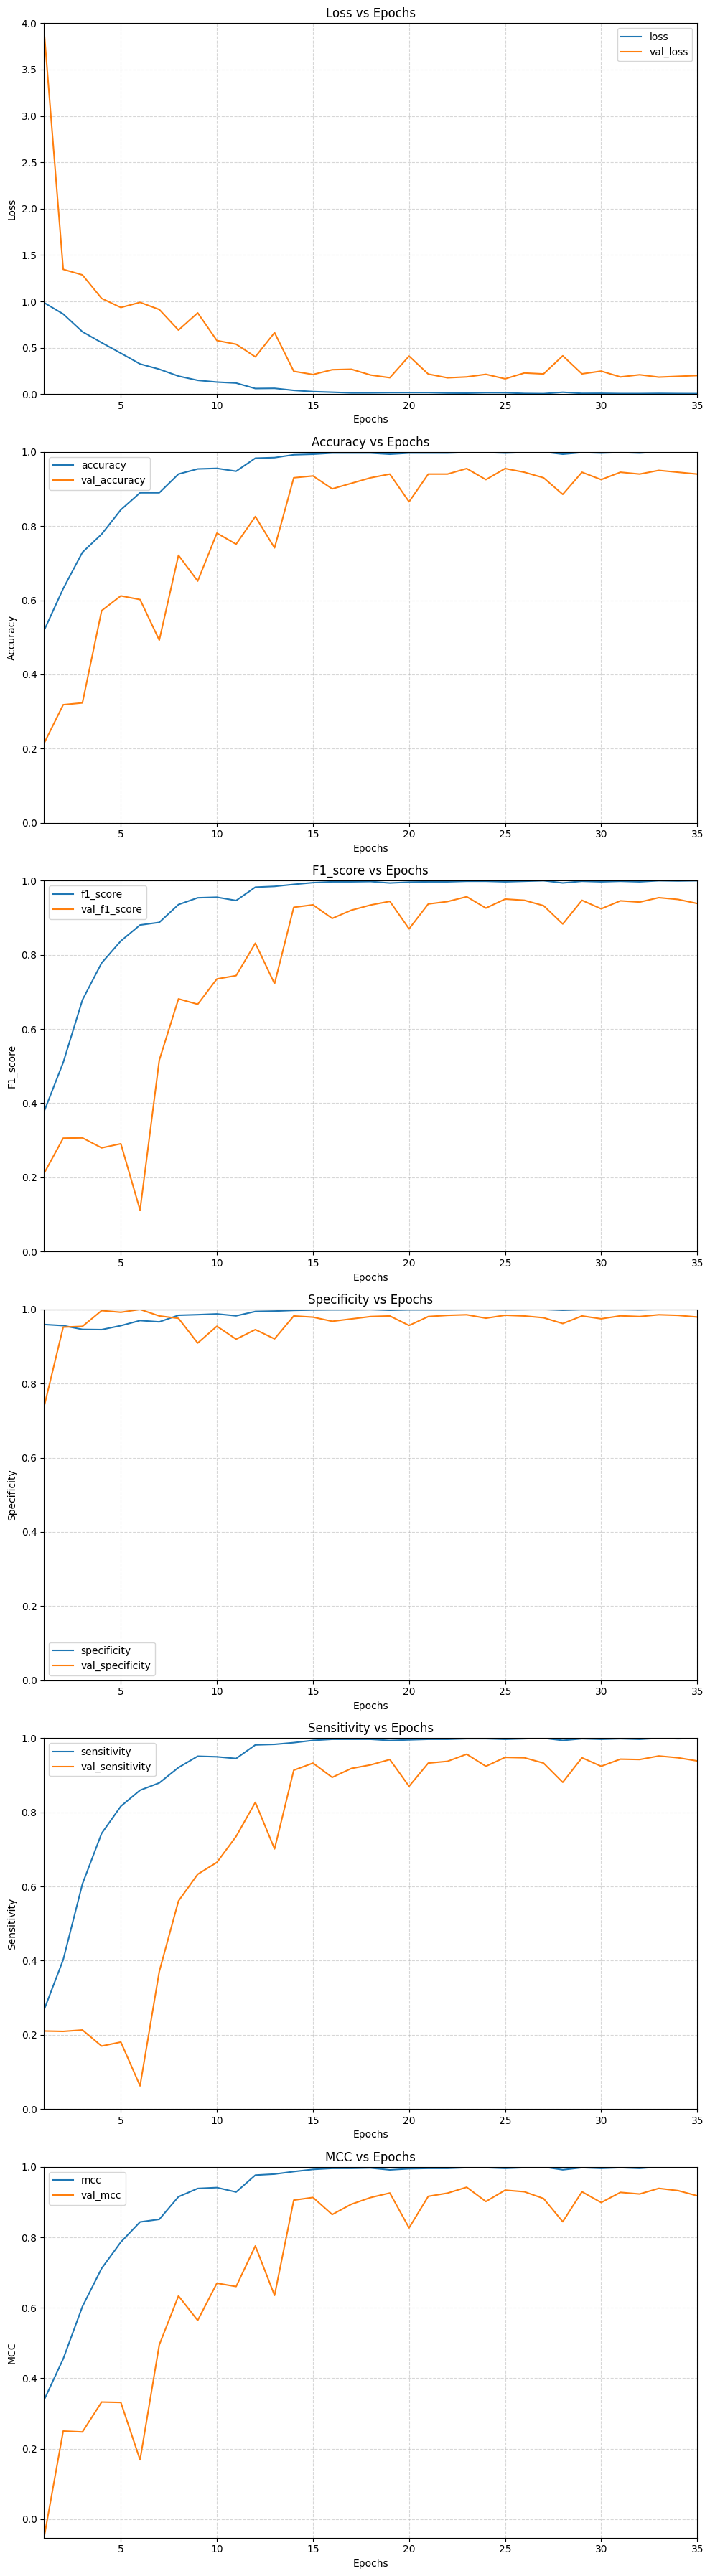

In [21]:
metric_names = ["loss", "accuracy","f1_score",
                "specificity", "sensitivity", "mcc"]
plot_metrics(history, metric_names)

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [23]:
# Load the test dataset
X_test, y_test = [], []
for i in range(len(test_generator)):
    batch_X, batch_y = test_generator[i]
    X_test.append(batch_X)
    y_test.append(batch_y)
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert the one-hot encoded predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert the one-hot encoded true labels to class labels
y_true_classes = np.argmax(y_test, axis=1)

# Create a classification report
report = classification_report(y_true_classes, y_pred_classes)

print(report)

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 539ms/step
              precision    recall  f1-score   support

           0       0.95      0.86      0.90        49
           1       0.96      0.93      0.94        27
           2       0.89      1.00      0.94        31
           3       0.90      0.95      0.92        38

    accuracy                           0.92       145
   macro avg       0.93      0.93      0.93       145
weighted avg       0.93      0.92      0.92       145



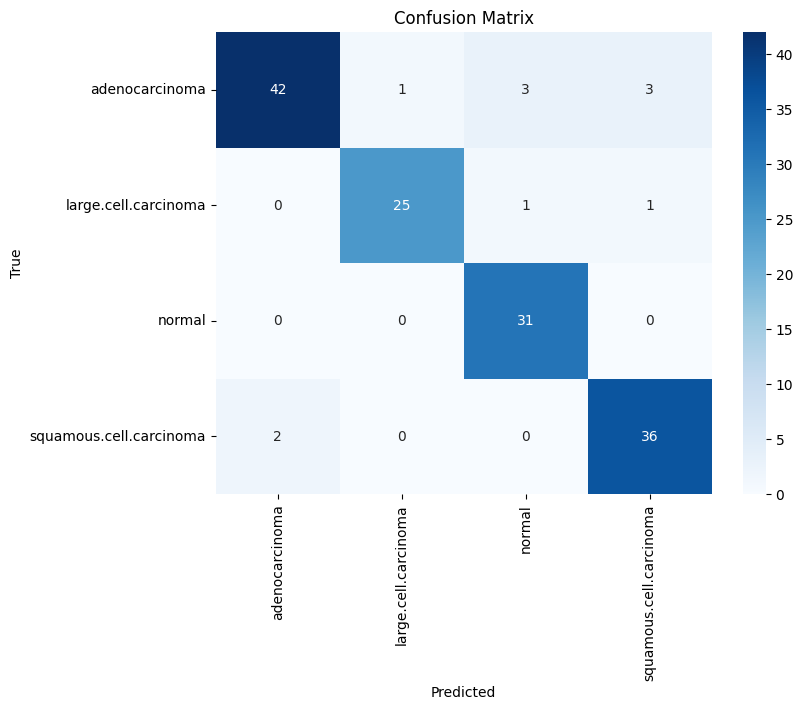

In [24]:
class_names = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()